In [7]:
%run supportvectors-common.ipynb



<div style="color:#aaa;font-size:8pt">
<hr/>

 </blockquote>
 <hr/>
</div>



# Our first neural architecture

We will build a simple neural architecture to solve a problem in linear regression.

In [19]:
from svlearn.approximator.regression_network import SimpleFeedForwardNetwork
from svlearn.approximator.sample_data import create_regression_data
from svlearn.approximator.helpers import create_plots
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn import MSELoss
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt

## Batch Gradient Descent

First let us create some data, comprising of a single predictor variable, and the response.

### Homework
Review the source code of the function `create_regression_data ()`. Make sure you understand it completely. Reach out to us for help if needed.

In [20]:
X_tensor, y_tensor = create_regression_data()

In [21]:
# Get the training parts ready
network = SimpleFeedForwardNetwork()
print(network)
network.activation = torch.relu # Rectified Linear Unit
loss_function = MSELoss()
optimizer = Adam(network.parameters(), lr=0.01)

# Let us now train the network
losses = []
epochs = 2001
drop_out = 0.1
for epoch in range(epochs):

    optimizer.zero_grad()  # reset the gradients
    results = network(X_tensor, drop_out)  # get predictions
    loss = loss_function(results, y_tensor)  # estimate loss
    loss.backward()  # back-propagate gradients
    optimizer.step()  # update the parameter values (gradient-descent)
    losses.append(loss.data)  # keep track of the loss of this epoch
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data))

SimpleFeedForwardNetwork(
  (network): Sequential(
    (fc0): Linear(in_features=1, out_features=128, bias=True)
    (activation0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (activation2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (output): Linear(in_features=16, out_features=1, bias=True)
  )
)
----------------------------------------------------------------------------------------------------

| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
----------------------------------------------------------------------------------------------------

|  fc0   |       1        |      128       |    128     |    128     |     256      |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |    

In [22]:
# And now, use the trained model to make predictions
# It is necessary to enter the evaluation model, and exit training.
network.eval()
final_outputs = network(X_tensor)

### Plot the results of batch gradient descent on the data

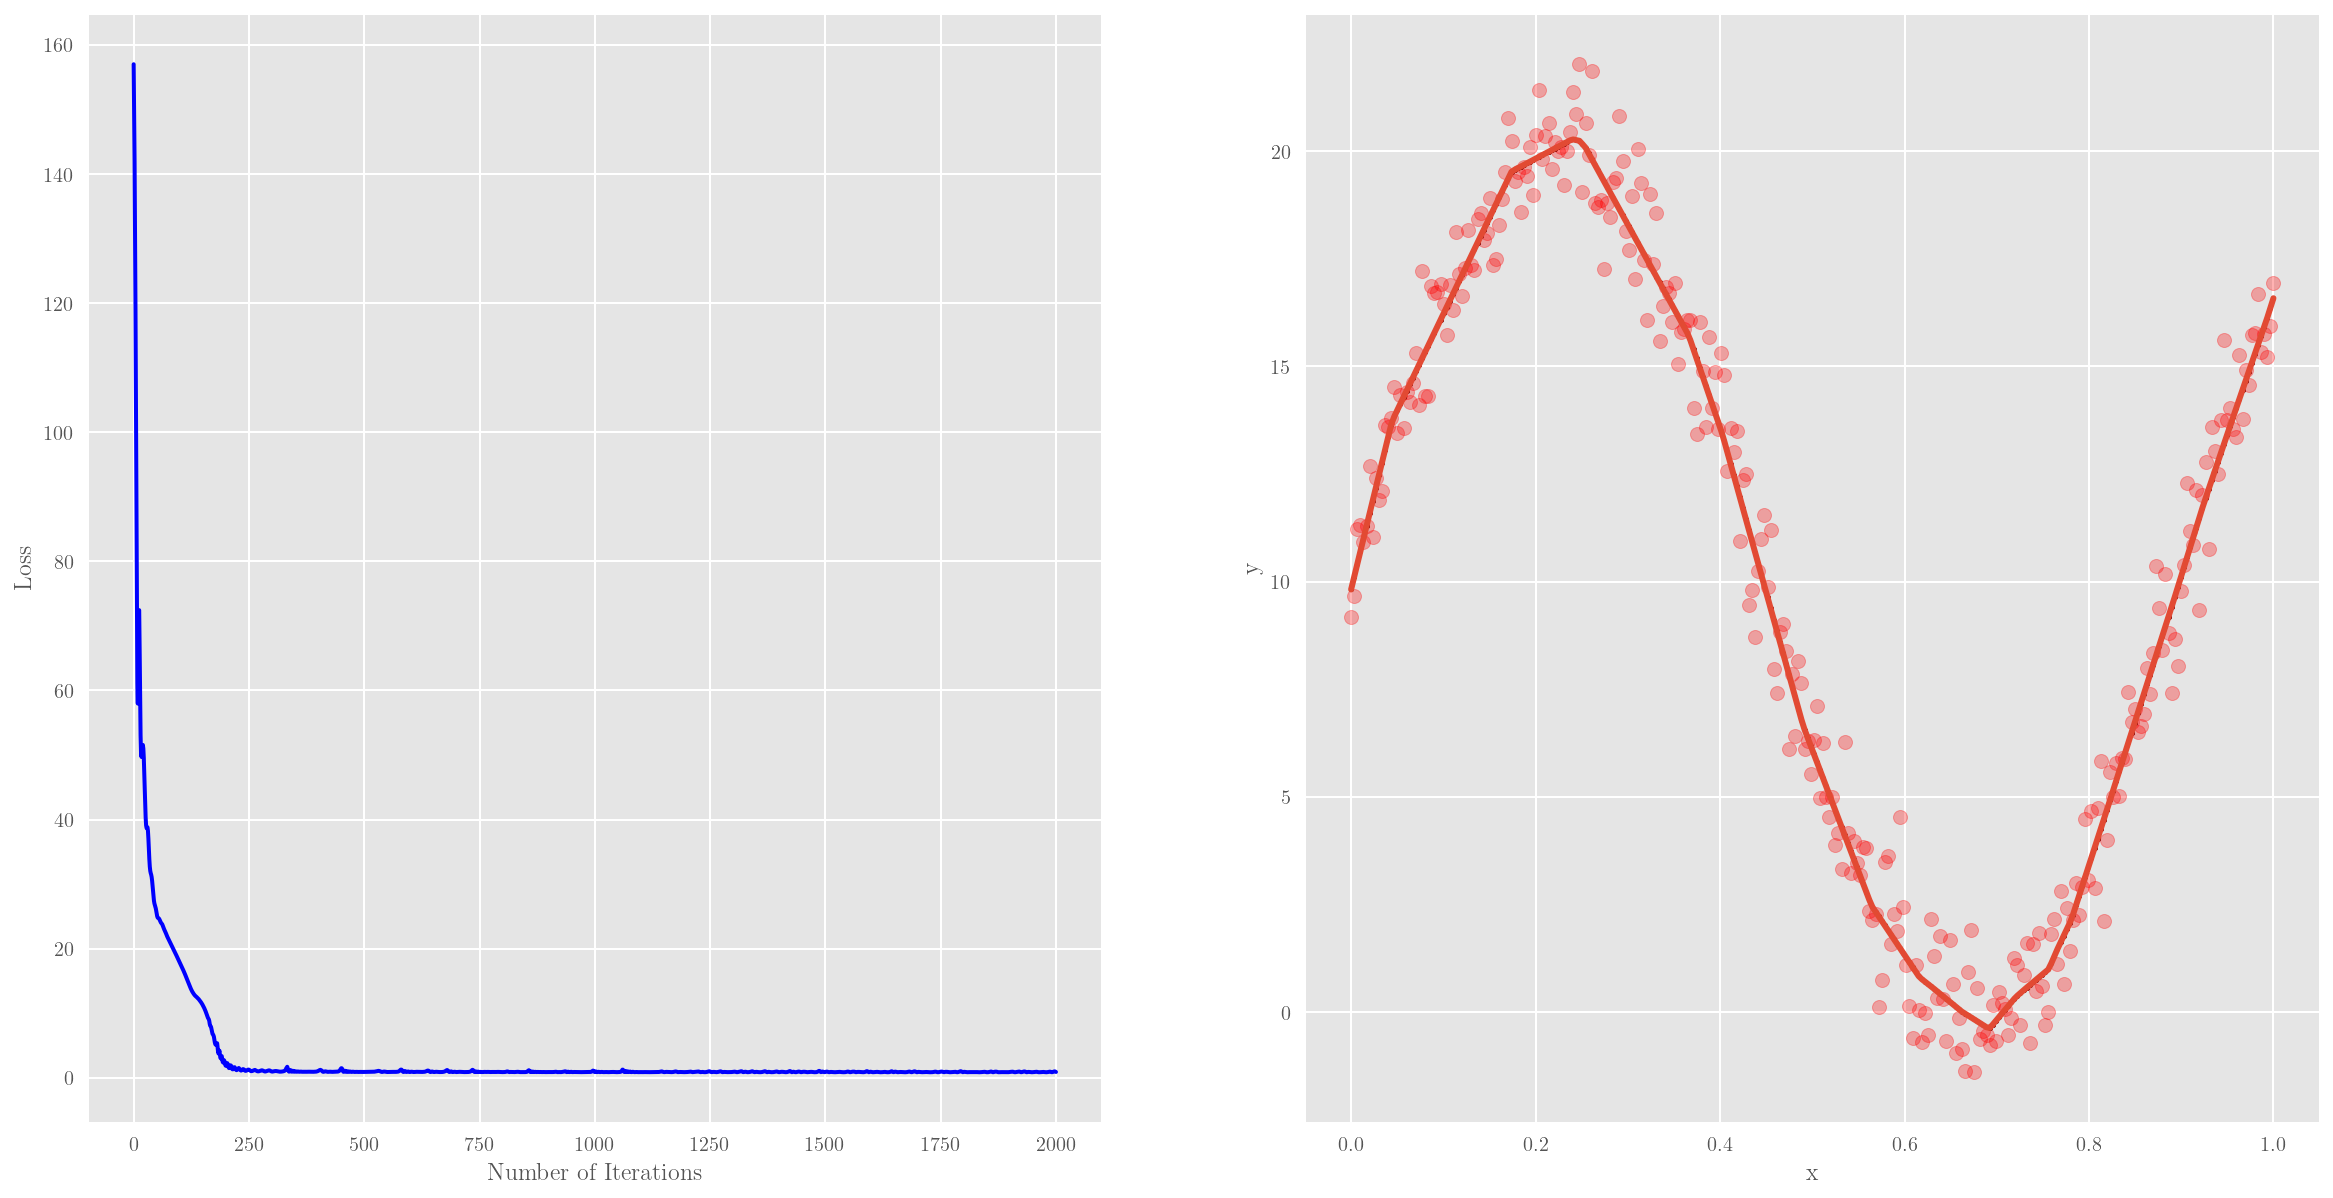

In [23]:
#
# The conversion to numpy arrays from tensors will happen automatically
# internally while plotting. So do not need to call .numpy()
#
# How, you do have to make sure that the tensors are detached; otherwise
# .numpy() cannot be called on them.
#
y_hat = final_outputs.detach()
x = X_tensor.detach()
y = y_tensor
create_plots(x, y, y_hat, epochs, losses)

## Mini-batch Gradient Descent

Here, at each step, we learn from from mini batches of data. So forth this, the dataloader returns data in small batches. The mini-batch size is specified in the pytorch dataloader by the parameter `batch_size`


In [25]:
sample_size = 1000
X = np.linspace(0, 1, sample_size)
y = 10 * (1 + np.sin(7 * X))
y += np.random.normal(0,1, sample_size)

dataset = SimpleNumpyDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


epochs = 1001
drop_out = 0.1
# Get the training parts ready
network = SimpleFeedForwardNetwork()
print(network)
loss_function = MSELoss()
optimizer = Adam(network.parameters(), lr=0.001)
losses = []
steps = 0
for epoch in range(epochs):
    start = True
    for data, labels in loader:
        optimizer.zero_grad()  # reset the parameter gradients
        results = network(data, drop_out)  # get predictions
        loss = loss_function(results, labels)  # estimate loss
        loss.backward()  # back-propagate gradients
        optimizer.step()  # update the parameter values (gradient-descent)
        losses.append(loss.data)  # keep track of the loss of this epoch
        if epoch % 100 == 0 and start:
            print('epoch {}, loss {}'.format(epoch, loss.data))
        start = False
        steps +=1

SimpleFeedForwardNetwork(
  (network): Sequential(
    (fc0): Linear(in_features=1, out_features=128, bias=True)
    (activation0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (activation2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (output): Linear(in_features=16, out_features=1, bias=True)
  )
)
----------------------------------------------------------------------------------------------------

| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
----------------------------------------------------------------------------------------------------

|  fc0   |       1        |      128       |    128     |    128     |     256      |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |    

### Let us now see how well the model has learned from the data.

In [26]:
# And now, use the trained model to make predictions
# It is necessary to enter the evaluation model, and exit training.
network.eval()
xtest = np.array(X, dtype=np.float32).reshape(-1, 1)
xtest_tensor = torch.from_numpy(xtest)
outputs = network(xtest_tensor)

### Plot the results of MINI-BATCH gradient descent on the data

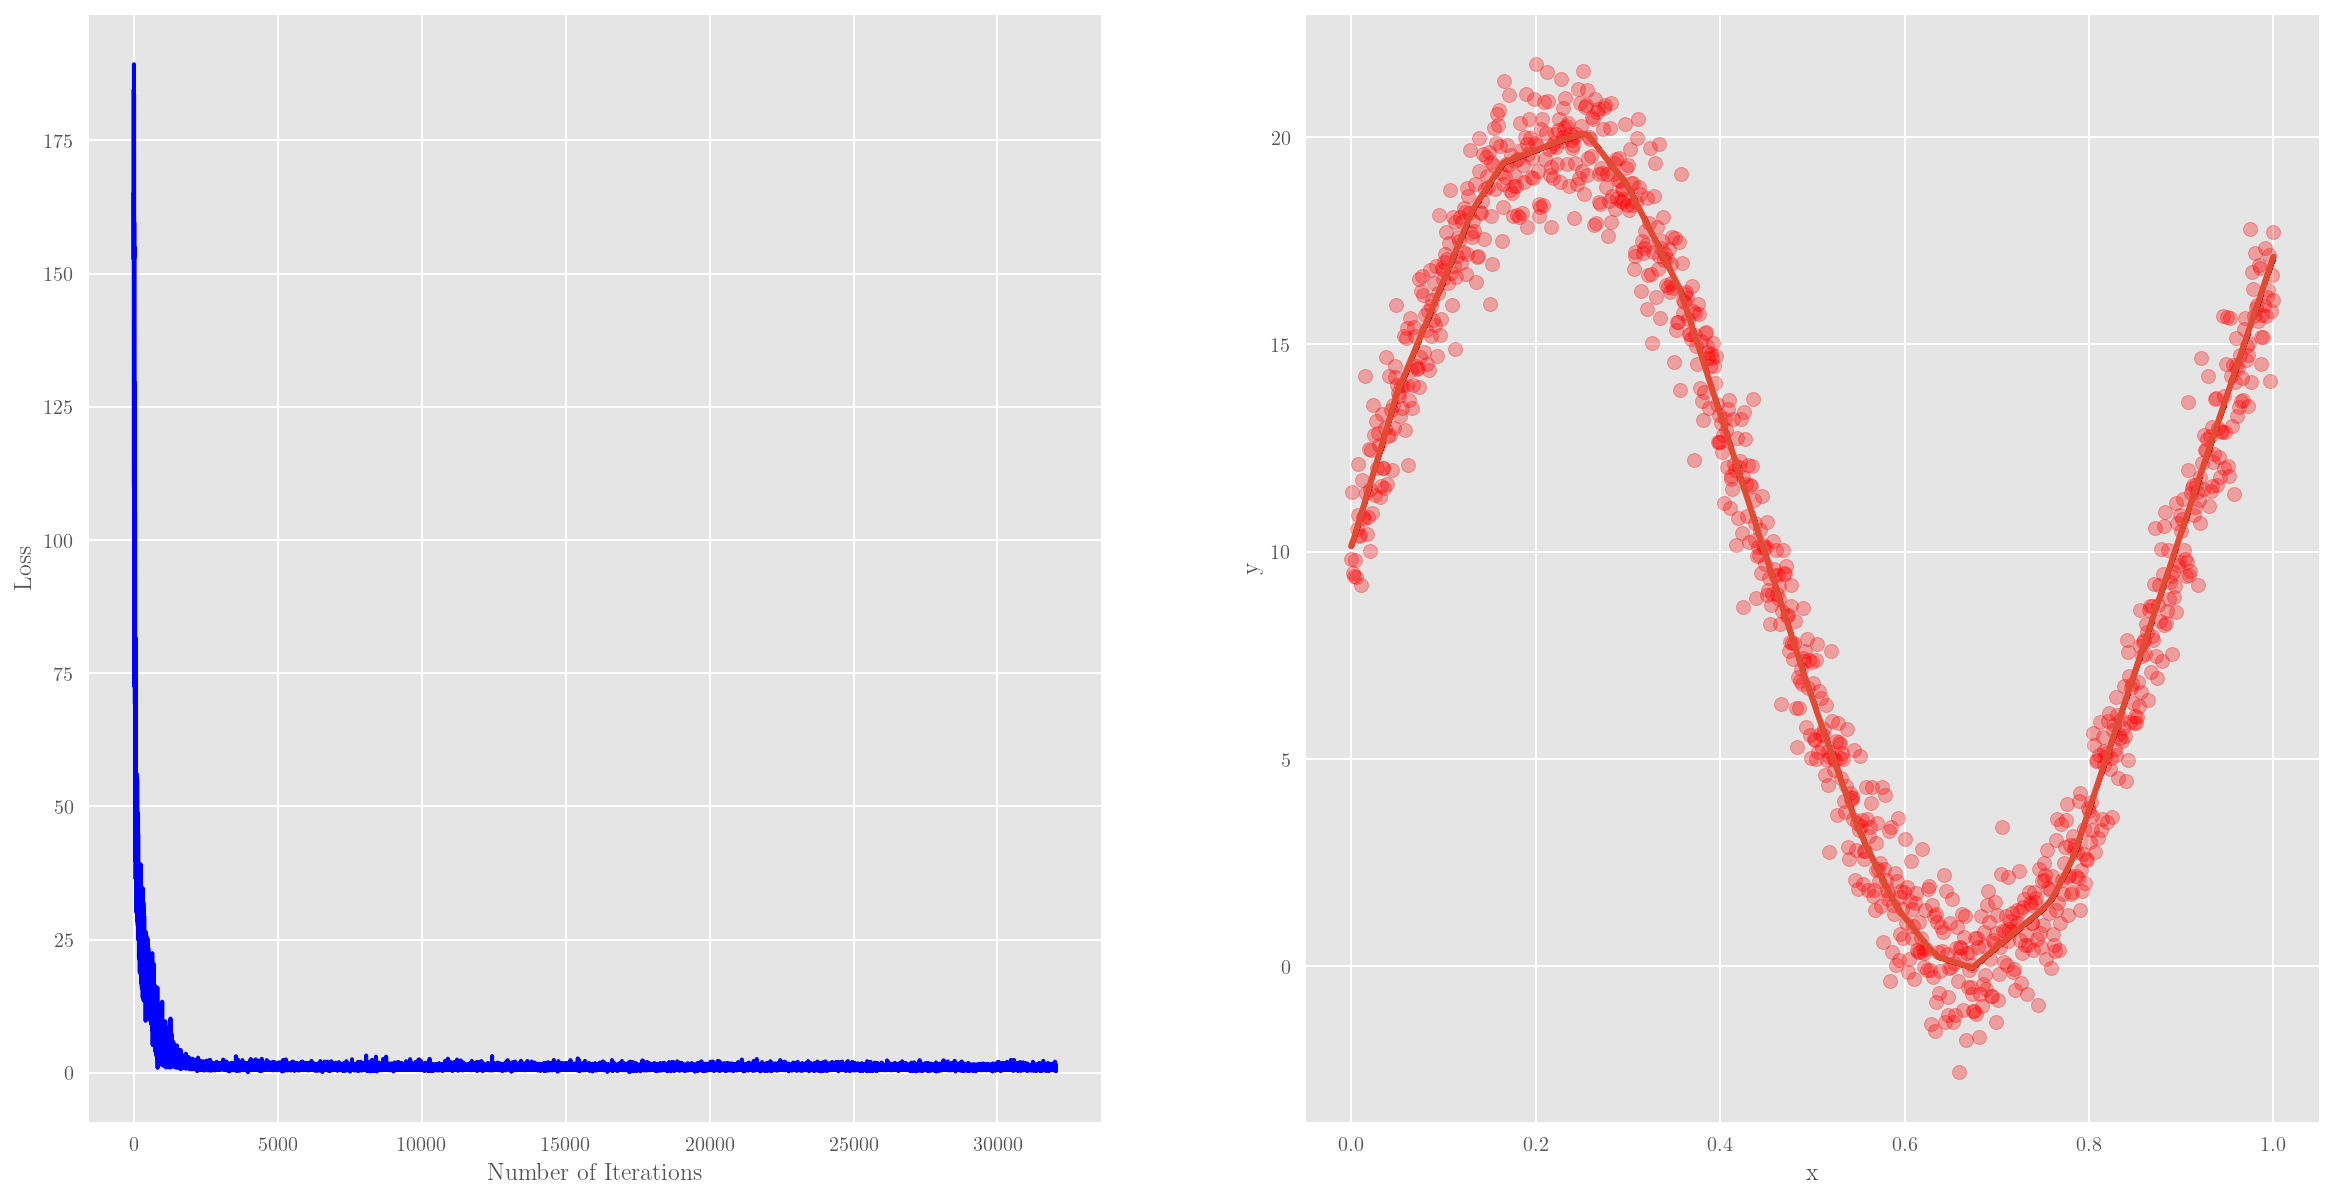

In [27]:
yyhat = outputs.detach().numpy().reshape(-1,1)
create_plots(X, y, yyhat, steps, losses)

## Stochastic Gradient Descent

Here, each step of learning is from one datum. So an epoch will have as many steps as the training sample size. Let us see how well it does.


In [28]:
# Note how we have set the mini-batch size to 1!
loader = DataLoader(dataset, batch_size=1, shuffle=True)
epochs = 1001
drop_out = 0.1
# Get the training parts ready
network = SimpleFeedForwardNetwork()

print(network)
loss_function = MSELoss()
optimizer = SGD(network.parameters(), lr=0.001)
losses = []
steps = 0
for epoch in range(epochs):
    start = True
    for data, labels in loader:
        optimizer.zero_grad()  # reset the parameter gradients
        results = network(data, drop_out)  # get predictions
        loss = loss_function(results, labels)  # estimate loss
        loss.backward()  # back-propagate gradients
        optimizer.step()  # update the parameter values (gradient-descent)
        losses.append(loss.data)  # keep track of the loss of this epoch
        if epoch % 100 == 0 and start:
            print('epoch {}, loss {}'.format(epoch, loss.data))
        start = False
        steps +=1

SimpleFeedForwardNetwork(
  (network): Sequential(
    (fc0): Linear(in_features=1, out_features=128, bias=True)
    (activation0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (activation1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (activation2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (output): Linear(in_features=16, out_features=1, bias=True)
  )
)
----------------------------------------------------------------------------------------------------

| LAYER  |  IN FEATURES   |  OUT FEATURES  |  WEIGHTS   |   BIASES   | TOTAL PARAMS |
----------------------------------------------------------------------------------------------------

|  fc0   |       1        |      128       |    128     |    128     |     256      |
|  fc1   |      128       |       64       |    8192    |     64     |     8256     |
|  fc2   |    

**Note how slow the training has gone, since we now have a huge number of steps.**

### Let us now see how effective the SGD optimizer has been

In [29]:
# And now, use the trained model to make predictions
# It is necessary to enter the evaluation model, and exit training.
network.eval()
xtest = np.array(X, dtype=np.float32).reshape(-1, 1)
xtest_tensor = torch.from_numpy(xtest)
outputs = network(xtest_tensor)

### Plot the results of Stochastic gradient descent optimization based learning from the data

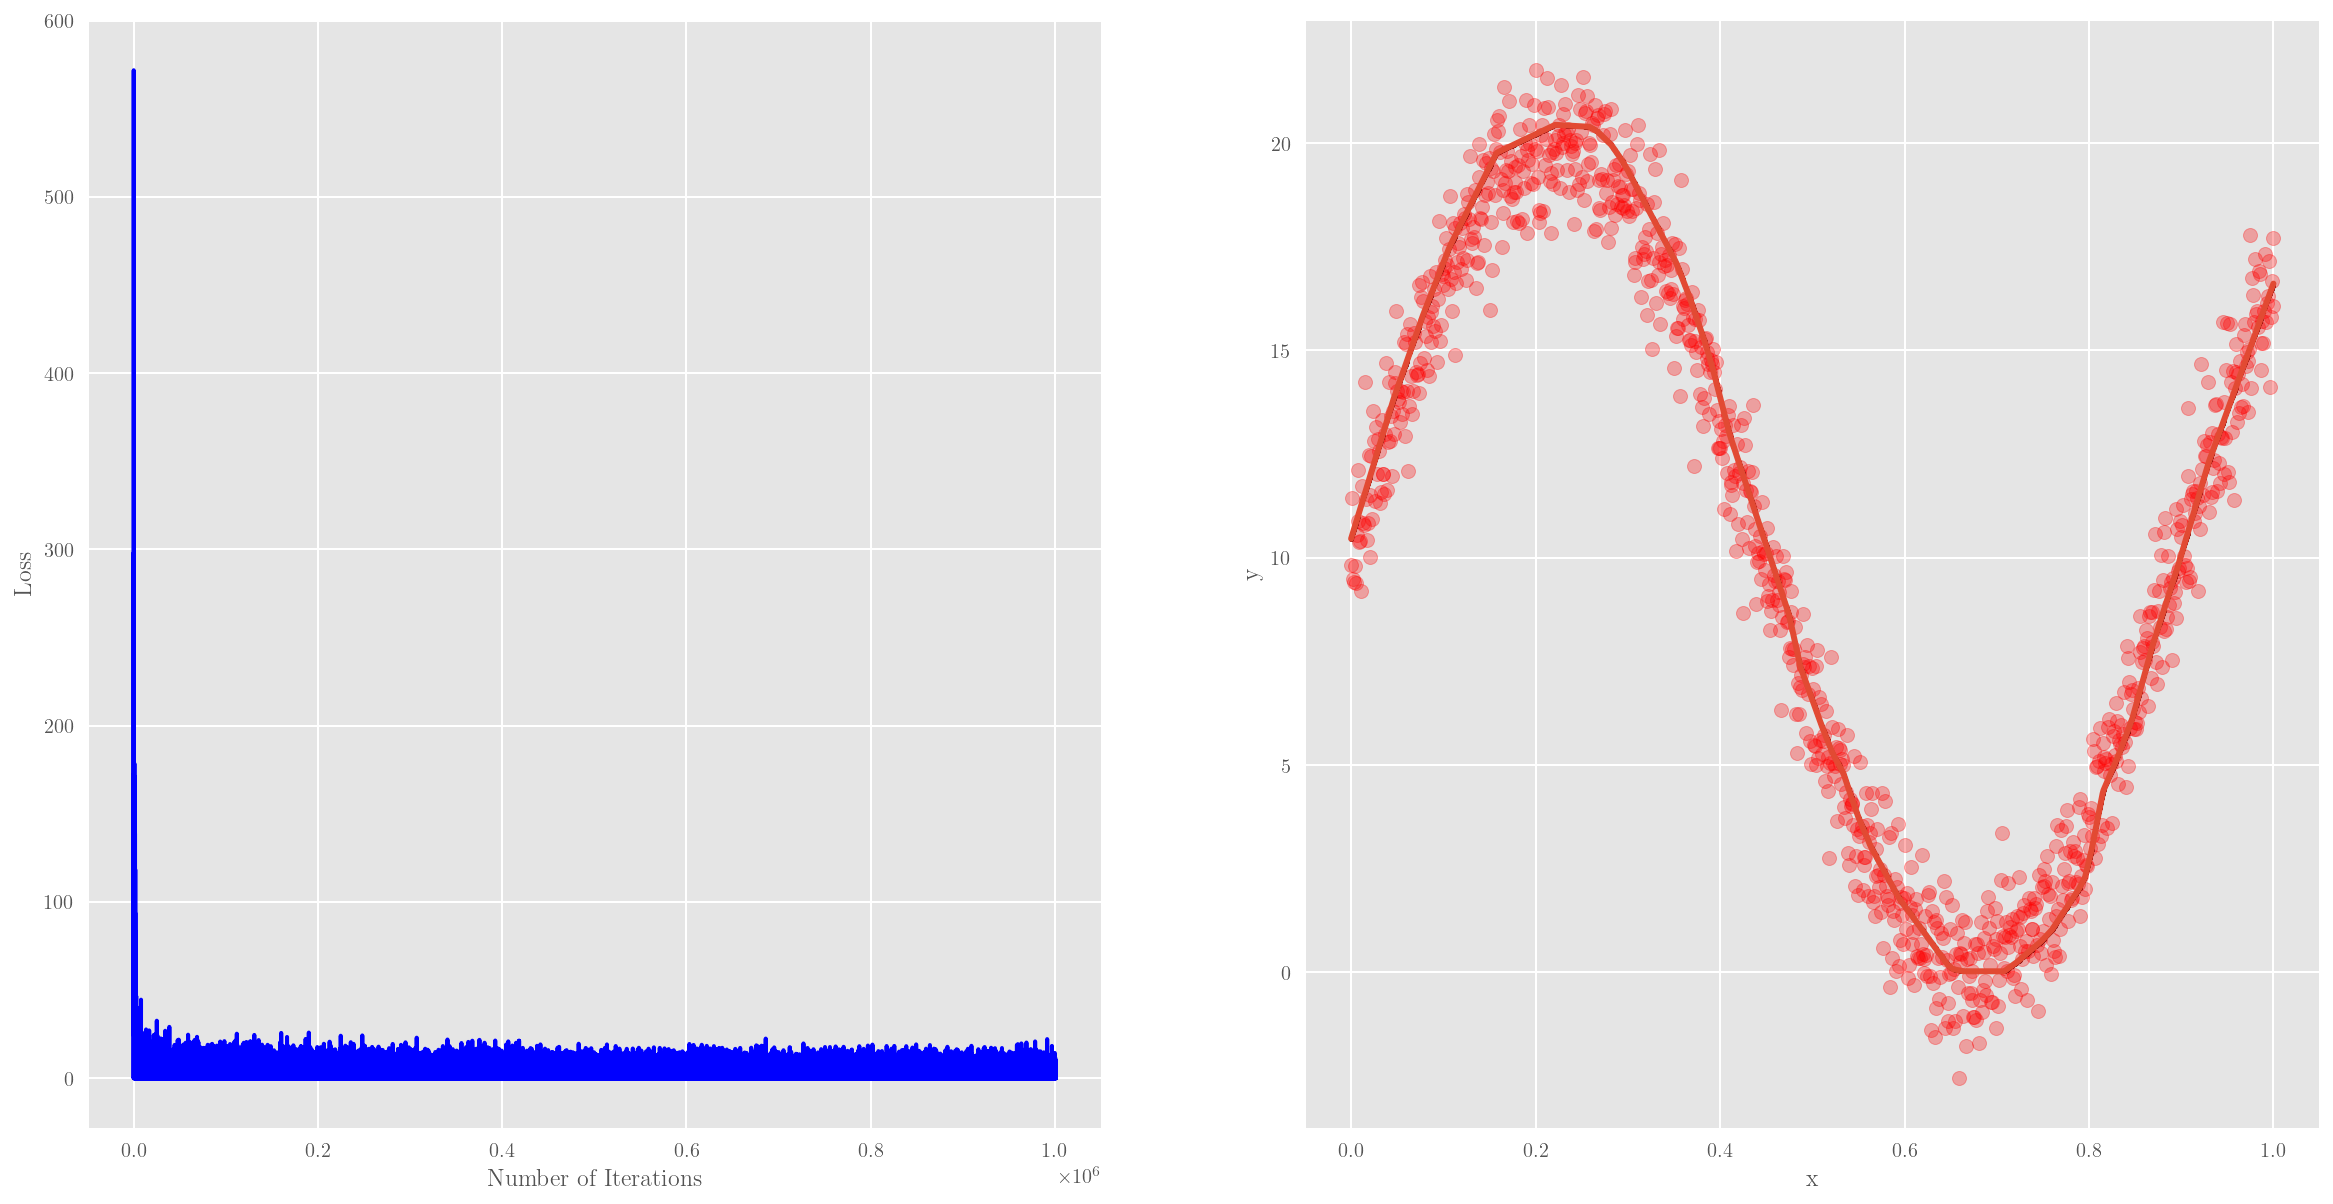

In [30]:
yyhat = outputs.detach().numpy().reshape(-1,1)
create_plots(X, y, yyhat, steps, losses)